# Toy optimisation

The first steps at analysing optimal controls for a malaria model. We look at three constant controls:

 * spraying coverage,
 * bednet coverage, and
 * proportion of treated individuals

In [1]:
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import numpy as np

In [2]:
det = importr('ICDMM')
base = importr('base')

In [3]:
data = base.readRDS('./msparams/GTS2020_sites_fitted.RDS')

In [4]:
sim_length = 365
location_index = 0
seasonality = data[10]
vectors = data[6]

def get_run(itn, irs, ft):
    return det.run_model(
        ssa0 = seasonality[location_index].rx2['seasonal_a0'],
        ssa1 = seasonality[location_index].rx2['seasonal_a1'],
        ssa2 = seasonality[location_index].rx2['seasonal_a2'],
        ssa3 = seasonality[location_index].rx2['seasonal_a3'],
        ssb1 = seasonality[location_index].rx2['seasonal_b1'],
        ssb2 = seasonality[location_index].rx2['seasonal_b2'],
        ssb3 = seasonality[location_index].rx2['seasonal_b3'],
        eta  = 1 / (21 * 365),
        Q0   = ro.FloatVector([
            np.average(
                vectors[location_index][6:13:3],
                weights=vectors[location_index][0:3]
            )
        ]),
        time = sim_length,
        init_EIR = data.rx2['total_M'][location_index], # TODO: get acutal baseline EIR
        ITN_IRS_on = 0,
        itn_cov = itn,
        irs_cov = irs,
        num_int = 4,
        init_ft = ft
    )

# Objective

We look at an objective function which maximises the reduction prevalence and minimises the cost of actions.

 * Each action is weighted based on its cost [paper](https://www.sciencedirect.com/science/article/pii/S0303264712002067)
 * The importance of prevalence is weighted against costs based on w_prev

In [5]:
cf = get_run(0, 0, 0)

def objective(x):
    itn, irs, ft = x
    run = get_run(itn, irs, ft)
    prev = np.mean(np.array(run.rx2['prev']))
    cf_prev = np.mean(np.array(cf.rx2['prev']))
    population = 1e5
    w_prev = .9
    c_itn = 3.625
    c_irs = 1.5
    c_ft  = 2
    return sum((
        w_prev * (prev - cf_prev),
        (1 - w_prev) * sum((
            c_itn * itn,
            c_irs * irs,
            c_ft * ft * sum(np.array(run.rx2['inc']))
        ))
    ))

In [6]:
from skopt import gp_minimize

# Optimisation

We search for coverage levels which minimise the objective:

 * Bayesian optimisation with a GP surrogate
 * Proability of improvement
 * 100 function calls

In [7]:
%%time
result = gp_minimize(
    objective,
    dimensions = [(0., 1.), (0., 1.), (0., 1.)],
    initial_point_generator = 'lhs',
    acq_func = 'PI',
    random_state = 42
)
print(result.x)

[0.000963701912947146, 0.009900679095621425, 0.9587112705941466]
CPU times: user 3min 4s, sys: 41.2 s, total: 3min 45s
Wall time: 1min 32s


In [8]:
from skopt.plots import plot_evaluations, plot_objective, plot_convergence

There's a very quick convergence

<AxesSubplot:title={'center':'Convergence plot'}, xlabel='Number of calls $n$', ylabel='$\\min f(x)$ after $n$ calls'>

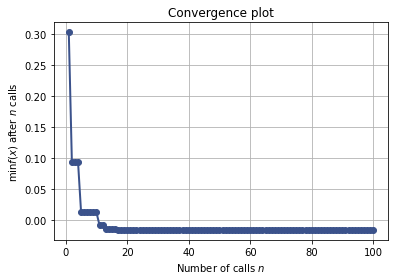

In [9]:
plot_convergence(result)

And a clear preference towards treatment

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Number of samples'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Number of samples'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{2}$'>,
        <AxesSubplot:xlabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{2}$', ylabel='Number of samples'>]],
      dtype=object)

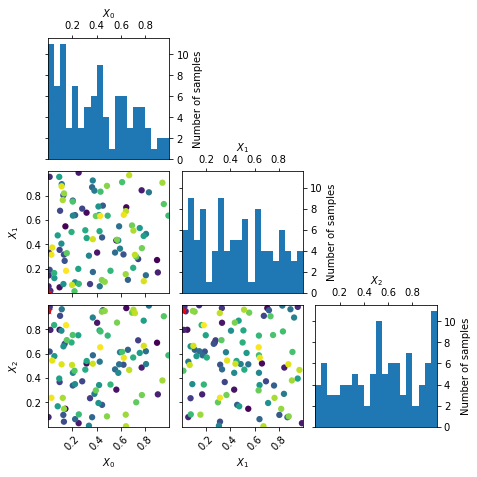

In [10]:
plot_evaluations(result)

array([[<AxesSubplot:xlabel='$X_{0}$', ylabel='Partial dependence'>,
        <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:ylabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{1}$', ylabel='Partial dependence'>,
        <AxesSubplot:>],
       [<AxesSubplot:xlabel='$X_{0}$', ylabel='$X_{2}$'>,
        <AxesSubplot:xlabel='$X_{1}$'>,
        <AxesSubplot:xlabel='$X_{2}$', ylabel='Partial dependence'>]],
      dtype=object)

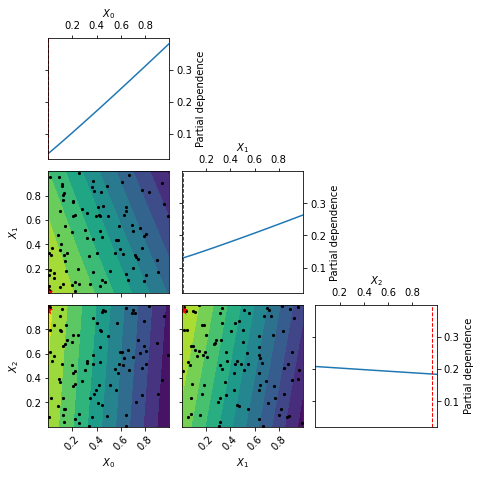

In [11]:
plot_objective(result)

TODO:

 * time-varying actions (large)
     * time-differentiable model
     * HJB
 * more realistic model
     * Swap in IBM
     * Initialise based on history
     * Model spatial aspects
 * more realistic objective
     * Eradication
     * A better way to separate multi-objectives
     * Economics??
 * extended actions
     * for countries
     * for international co-operation
 * uncertainty
     * based on bounds for non action parameters